In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import warnings
import sklearn
import pickle
from collections import defaultdict
warnings.filterwarnings('ignore')


## Data Preprocessing
### Detect and crop faces

In [63]:
from os.path import dirname, join as pjoin
import scipy.io as sio

In [64]:
mat_contents = sio.loadmat('./data/raw_data/wiki.mat')

In [65]:
path = pd.Series(mat_contents['wiki']['full_path'][0][0][0]).apply(lambda x: x[0])
gender = pd.Series(mat_contents['wiki']['gender'][0][0][0])
df = pd.DataFrame([path, gender]).T
df = df.rename({0:'path', 1:'gender'},axis=1).dropna()
df.path = './data/raw_data/' + df.path
df.gender = df.gender.astype(int)
df.head()
# 1 represents male, while 0 represents female

,path,gender
0,./data/raw_data/17/10000217_1981-05-05_2009.jpg,1
1,./data/raw_data/48/10000548_1925-04-04_1964.jpg,1
2,./data/raw_data/12/100012_1948-07-03_2008.jpg,1
3,./data/raw_data/65/10001965_1930-05-23_1961.jpg,1
4,./data/raw_data/16/10002116_1971-05-31_2012.jpg,0


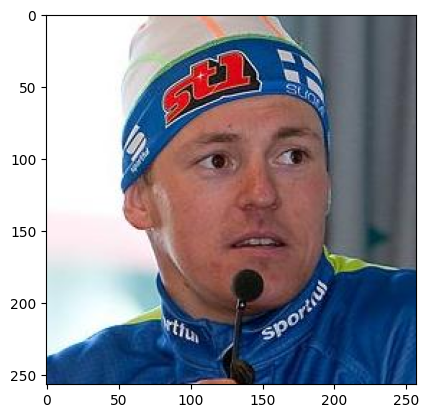

In [66]:
# Display the first image in the dataframe
img_bgr = cv2.imread(df.path[0])
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

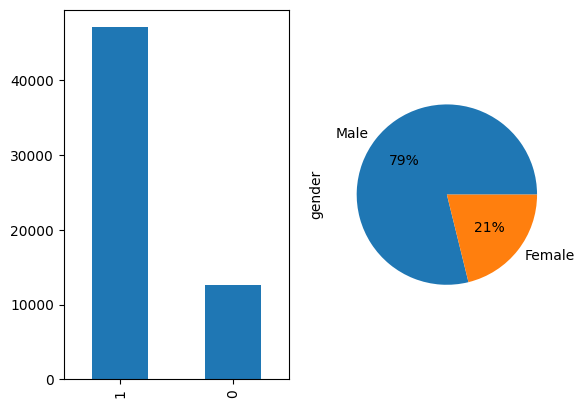

In [67]:
fig,ax = plt.subplots(nrows=1,ncols=2)
df.gender.value_counts().plot(kind='bar',ax=ax[0])
df.gender.replace({0: 'Female', 1:'Male'}).value_counts().plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.show()

The dataset is imbalanced. We will first try to reduce the number of images of male to 20000

In [68]:
df = df.sort_values('gender')[:df.gender.value_counts()[0] + 20000].reset_index().drop('index', axis=1)
df.gender.value_counts()

1    20000
0    12622
Name: gender, dtype: int64

In [69]:
df.shape

(32622, 2)

In [70]:
cropped_df = pd.DataFrame(columns=['path', 'gender', 'dimension'])


for i in range(len(df)):
    try:
        img_bgr = cv2.imread(df.path[i])
        # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        faces = haar.detectMultiScale(img_gray, 1.5, 5)
        for x,y,w,h in faces:
            cv2.rectangle(img_bgr, (x,y), (x+w,y+h), (0,0,255),1)
            roi = img_bgr[y:y+h, x:x+w]
            cv2.imwrite(f'./data/cropped_data/{df.gender[i]}_{i}.jpg',roi)
            cropped_df = cropped_df.append({'path': f'./data/cropped_data/{df.gender[i]}_{i}.jpg', 'gender': df.gender[i], 'dimension': roi.shape[0]}, ignore_index=True)
    except:
        continue

### Resize the images
#### Exploratory Data Analysis

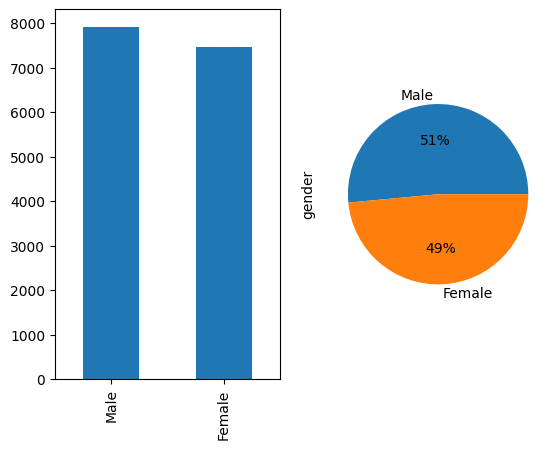

In [78]:
fig,ax = plt.subplots(nrows=1,ncols=2)
cropped_df.gender.replace({0: 'Female', 1:'Male'}).value_counts().plot(kind='bar',ax=ax[0])
cropped_df.gender.replace({0: 'Female', 1:'Male'}).value_counts().plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.show()

The data set is almost balanced.

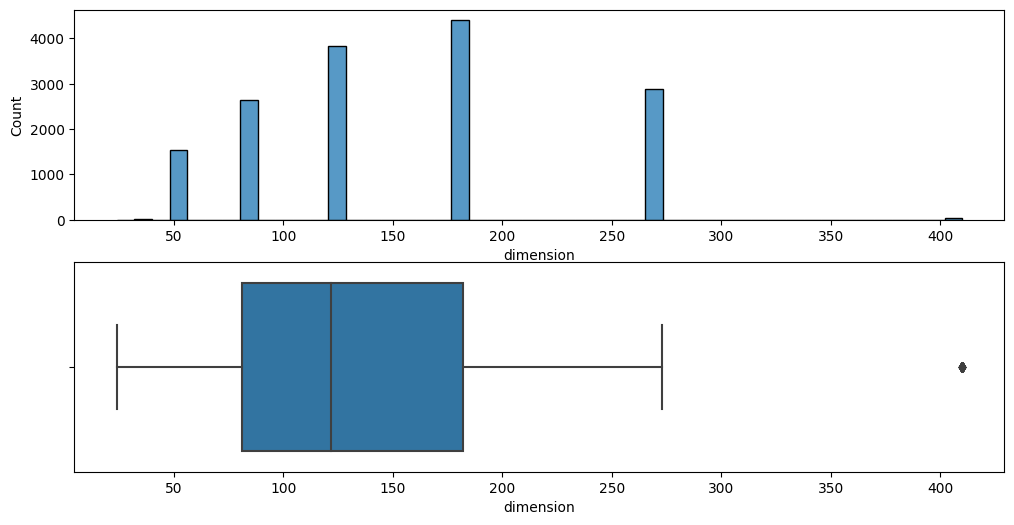

In [79]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
sns.histplot(cropped_df['dimension'])
plt.subplot(2,1,2)
sns.boxplot(cropped_df['dimension'])
plt.show()

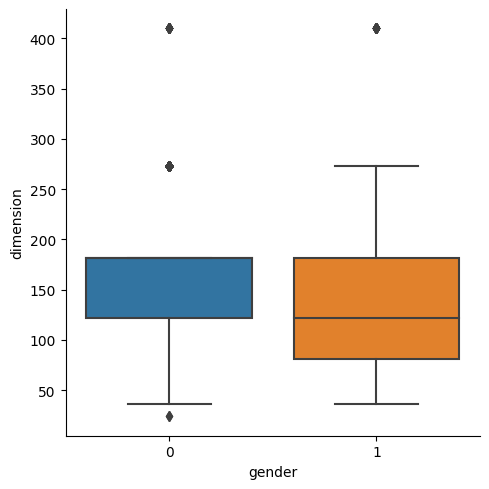

In [81]:
sns.catplot(data=cropped_df,x='gender',y='dimension',kind='box')

In [100]:
(cropped_df[cropped_df.gender == 0].dimension >= 80).sum()

6761

In [99]:
(cropped_df[cropped_df.gender == 1].dimension >= 80).sum()

7048

In [101]:
# Filter out imgages with dimension less than 80
cropped_df = cropped_df[cropped_df.dimension >= 80]

#### Resize all the the image into 100 x 100 and flatten

In [102]:
def resize_img(path):
    try:
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dim = len(img_gray)
        if dim <= 100:
            # INTER_AREA is for shrink
            img_gray = cv2.resize(img_gray, (100,100), cv2.INTER_AREA)
        else:
            # INTER_CUBIC is for enlarging
            img_gray = cv2.resize(img_gray, (100,100), cv2.INTER_CUBIC)
        
        return img_gray.flatten()
    
    except:
        return None
        

        

In [103]:
cropped_df['img'] = cropped_df['path'].apply(resize_img)

In [104]:
cropped_df.head()

,path,gender,dimension,img
0,./data/cropped_data/0_3.jpg,0,182,"[77, 80, 91, 75, 81, 84, 81, 79, 78, 72, 67, 7..."
1,./data/cropped_data/0_8.jpg,0,273,"[139, 100, 140, 112, 139, 136, 118, 160, 111, ..."
2,./data/cropped_data/0_13.jpg,0,81,"[74, 72, 70, 71, 71, 76, 77, 80, 77, 79, 80, 8..."
3,./data/cropped_data/0_13.jpg,0,122,"[74, 72, 70, 71, 71, 76, 77, 80, 77, 79, 80, 8..."
4,./data/cropped_data/0_15.jpg,0,182,"[70, 57, 57, 56, 59, 61, 62, 62, 62, 70, 72, 7..."


In [105]:
data = cropped_df['img'].apply(pd.Series)
data.columns = [f"pixel_{i}" for i in data.columns]
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9990,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999
0,77,80,91,75,81,84,81,79,78,72,...,58,65,80,90,62,74,70,80,87,85
1,139,100,140,112,139,136,118,160,111,42,...,59,51,63,76,78,103,113,97,80,58
2,74,72,70,71,71,76,77,80,77,79,...,54,57,74,93,103,104,106,100,87,64
3,74,72,70,71,71,76,77,80,77,79,...,54,57,74,93,103,104,106,100,87,64
4,70,57,57,56,59,61,62,62,62,70,...,136,136,140,133,134,132,128,123,121,124


### Data Normalization

In [107]:
data = data/255.0 
data['gender'] = cropped_df.gender
## remove the missing values
data.dropna(inplace=True)
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,gender
0,0.301961,0.313725,0.356863,0.294118,0.317647,0.329412,0.317647,0.309804,0.305882,0.282353,...,0.254902,0.313725,0.352941,0.243137,0.290196,0.274510,0.313725,0.341176,0.333333,0
1,0.545098,0.392157,0.549020,0.439216,0.545098,0.533333,0.462745,0.627451,0.435294,0.164706,...,0.200000,0.247059,0.298039,0.305882,0.403922,0.443137,0.380392,0.313725,0.227451,0
2,0.290196,0.282353,0.274510,0.278431,0.278431,0.298039,0.301961,0.313725,0.301961,0.309804,...,0.223529,0.290196,0.364706,0.403922,0.407843,0.415686,0.392157,0.341176,0.250980,0
3,0.290196,0.282353,0.274510,0.278431,0.278431,0.298039,0.301961,0.313725,0.301961,0.309804,...,0.223529,0.290196,0.364706,0.403922,0.407843,0.415686,0.392157,0.341176,0.250980,0
4,0.274510,0.223529,0.223529,0.219608,0.231373,0.239216,0.243137,0.243137,0.243137,0.274510,...,0.533333,0.549020,0.521569,0.525490,0.517647,0.501961,0.482353,0.474510,0.486275,0


### Save the data

In [108]:
import pickle
pickle.dump(data, open('./data/cropped_100*100.pickle', mode='wb'))

### Eigen Face using PCA

In [109]:
data = pickle.load(open('./data/cropped_100*100.pickle',mode='rb'))

In [160]:
X = data.drop('gender', axis=1).values
y = data['gender'].values.astype(int)

In [112]:
X.shape, y.shape

((13809, 10000), (13809,))

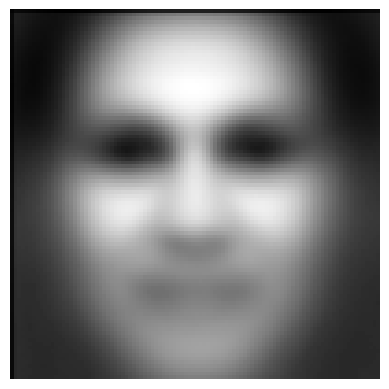

In [113]:
mean_face = X.mean(axis=0)
plt.imshow(mean_face.reshape((100,100)),cmap='gray')
plt.axis('off')
plt.show()

In [114]:
X = X - mean_face

In [116]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=None,whiten=True,svd_solver='auto')
pca.fit(X)

PCA(whiten=True)

In [117]:
exp_var = pd.DataFrame()
exp_var['explained_variance'] = pca.explained_variance_ratio_
exp_var['cumulative_explained_variance'] = exp_var['explained_variance'].cumsum()
exp_var['principal_components'] = np.arange(1,len(exp_var)+1)

exp_var.head()

,explained_variance,cumulative_explained_variance,principal_components
0,0.251951,0.251951,1
1,0.115970,0.367921,2
2,0.104610,0.472531,3
3,0.049592,0.522122,4
4,0.031995,0.554117,5


In [130]:
exp_var[exp_var['cumulative_explained_variance'] > 0.80] # Principle components that contribute over 80% of the explained variance

,explained_variance,cumulative_explained_variance,principal_components
40,2.113166e-03,0.800904,41
41,2.049219e-03,0.802953,42
42,1.962674e-03,0.804916,43
43,1.952782e-03,0.806868,44
44,1.940659e-03,0.808809,45
...,...,...,...
9995,3.116750e-09,1.000000,9996
9996,3.070061e-09,1.000000,9997
9997,3.011656e-09,1.000000,9998
9998,2.953447e-09,1.000000,9999


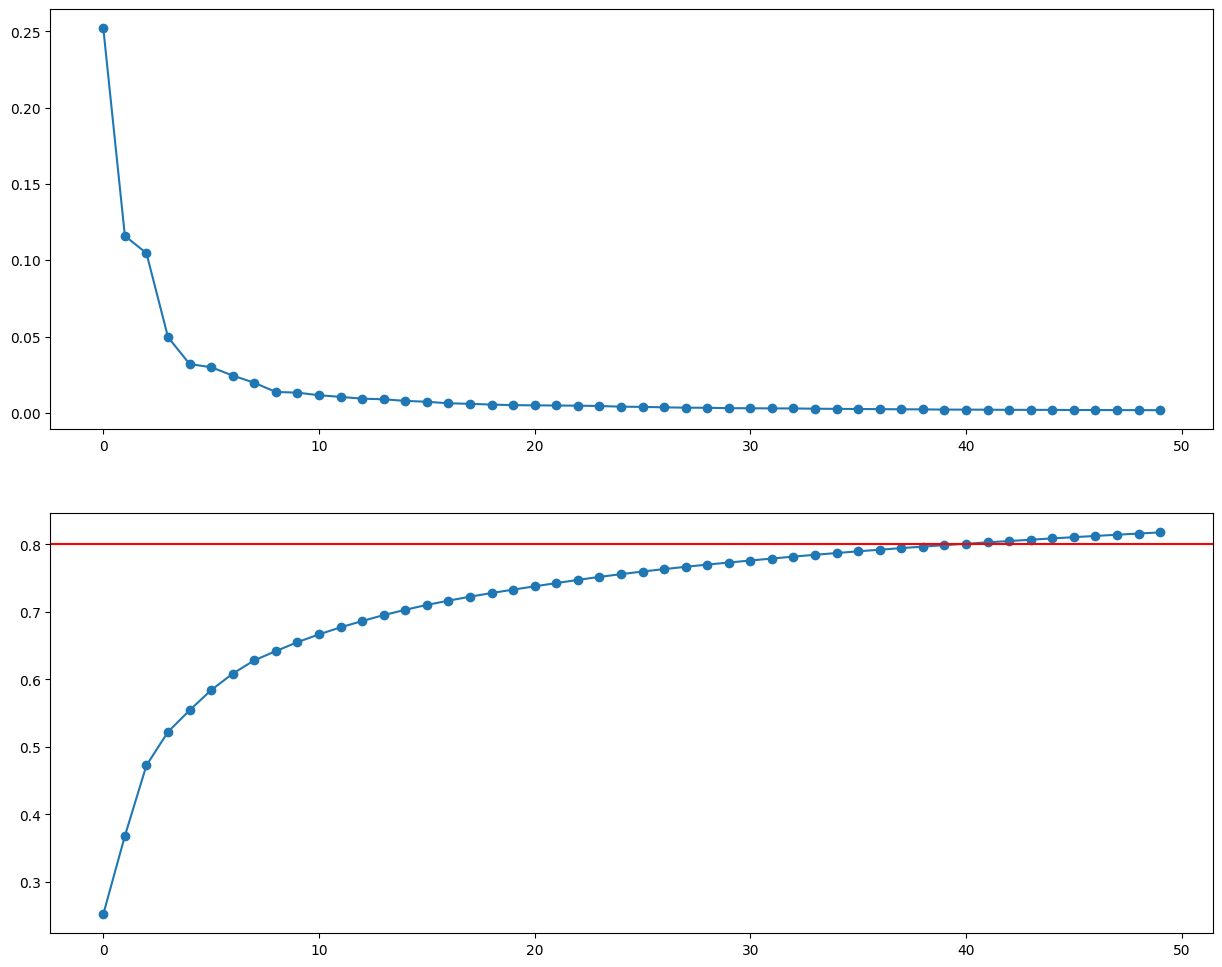

In [119]:
fig, ax = plt.subplots(nrows=2,figsize=(15,12))

exp_var['explained_variance'].head(50).plot(kind='line',marker='o',ax=ax[0])
exp_var['cumulative_explained_variance'].head(50).plot(kind='line',marker='o',ax=ax[1])
plt.axhline(y = 0.8, color = 'r', linestyle = '-')


50 pricipal components cover 80% of the explained variance.

In [135]:
pca = PCA(n_components=50,whiten=True,svd_solver='auto')
X_pca = pca.fit_transform(X)

In [136]:
X_pca.shape

(13809, 50)

In [137]:
# Visualize Eigen Image
pca_inv = pca.inverse_transform(X_pca)
pca_inv.shape

(13809, 10000)

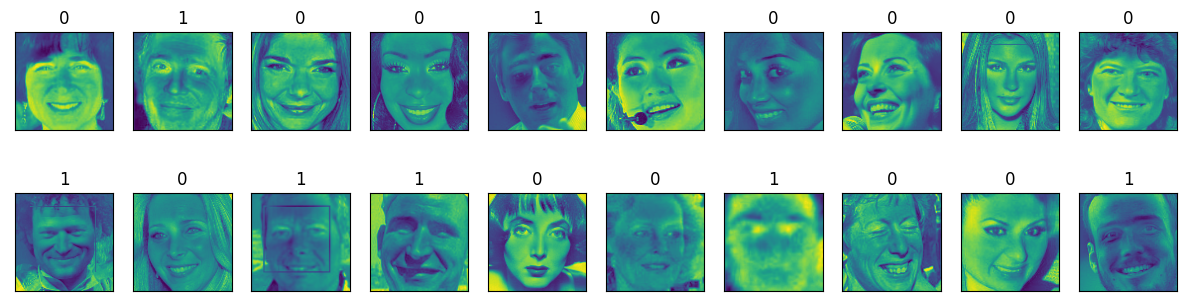

====================Eigen Images====================


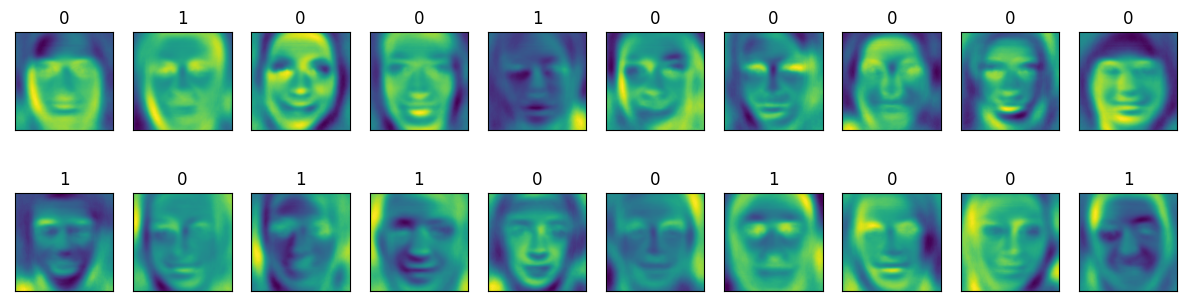

In [138]:
np.random.seed(1001)
pics = np.random.randint(0,len(X_pca),20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    
    img = X[pic].reshape(100,100)
    plt.imshow(img)
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = pca_inv[pic].reshape(100,100)
    plt.imshow(img)
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [140]:
# saving data and models
np.savez('./data/data_pca_50_target', X, y.astype(int))

pickle.dump({'pca':pca,'mean_face':mean_face}, open('model/pca_mean_face.pickle','wb'))

## SVC and grid search

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import VotingClassifier

In [161]:
X_train,X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.2, stratify = y) #stratify = y

In [162]:
# Fitting SVM model
svc = SVC(probability=True)
param_grid = {'C':[0.5,1,10,20,30,50],
             'kernel':['rbf','poly'],
             'gamma':[0.1,0.05,0.01,0.001,0.002,0.005],
             'coef0':[0,1]}
model_grid = GridSearchCV(svc,
                          param_grid=param_grid,
                          scoring='accuracy',cv=3,verbose=2)
model_grid.fit(X_train,y_train)

In [ ]:
model_svm = model_grid.best_estimator_
model_svm.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.05,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Fitting Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param_grid_lr = {'C':[0.001, 0.1,0.5,1,10,100,1000]}
model_grid_lr = GridSearchCV(lr,
                          param_grid=param_grid_lr,
                          scoring='accuracy',cv=3,verbose=2)
model_grid_lr.fit(X_train,y_train)
print(model_grid_lr.best_params_)
model_lr = model_grid_lr.best_estimator_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ............................................C=0.001; total time=   0.2s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ........................................

In [ ]:
# Fitting ramdom forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid_rf = {'max_depth':[2, 3,4, 5, 6,7,8,9,10, 11], 'n_estimators': [5, 10, 20, 50, 100]}
model_grid_rf = GridSearchCV(rf,
                          param_grid=param_grid_rf,
                          scoring='accuracy',cv=3,verbose=2)
model_grid_rf.fit(X_train,y_train)
print(model_grid_rf.best_params_)
model_rf = model_grid_rf.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=2, n_

In [208]:
# Fitting Voting Classifier
model_vote = VotingClassifier(estimators=[('svm', model_svm),
                                         ('rf', model_rf),
                                          ('lr', model_lr)],
                                          voting = 'soft',
                                          weights= [4, 1, 1.5])
model_vote.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(C=10, coef0=0, gamma=0.05, probability=True)),
                             ('rf', RandomForestClassifier(max_depth=11)),
                             ('lr', LogisticRegression(C=0.001))],
                 voting='soft', weights=[4, 1, 1.5])

### Model Evaluation based on 3 metrics
- Classification Report
- Kappa Score
- Area Under Curve (AUC)

**Classification Report**

In [210]:
print('='*20 + " SVM classification report "+'='*20)
classification_report_svm = metrics.classification_report(y_test,model_svm.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_svm).T)
print('='*20 + " Ramdom Forest classification report "+'='*20)
classification_report_rf = metrics.classification_report(y_test,model_rf.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_rf).T)
print('='*20 + " Logitstic Regression classification report "+'='*20)
classification_report_lr = metrics.classification_report(y_test,model_lr.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_lr).T)
print('='*20 + " Voting Classifier classification report "+'='*20)
classification_report_vote = metrics.classification_report(y_test,model_vote.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_vote).T)

==================== SVM classification report ====================


,precision,recall,f1-score,support
0,0.854460,0.807692,0.830418,1352.000000
1,0.824798,0.868085,0.845888,1410.000000
accuracy,0.838523,0.838523,0.838523,0.838523
macro avg,0.839629,0.837889,0.838153,2762.000000
weighted avg,0.839318,0.838523,0.838316,2762.000000


==================== Ramdom Forest classification report ====================


,precision,recall,f1-score,support
0,0.792779,0.747041,0.769231,1352.000000
1,0.770161,0.812766,0.790890,1410.000000
accuracy,0.780594,0.780594,0.780594,0.780594
macro avg,0.781470,0.779904,0.780061,2762.000000
weighted avg,0.781232,0.780594,0.780288,2762.000000


==================== Logitstic Regression classification report ====================


,precision,recall,f1-score,support
0,0.734996,0.697485,0.715750,1352.00000
1,0.723462,0.758865,0.740741,1410.00000
accuracy,0.728820,0.728820,0.728820,0.72882
macro avg,0.729229,0.728175,0.728245,2762.00000
weighted avg,0.729108,0.728820,0.728508,2762.00000


==================== Voting Classifier classification report ====================


,precision,recall,f1-score,support
0,0.846569,0.812130,0.828992,1352.000000
1,0.826621,0.858865,0.842435,1410.000000
accuracy,0.835988,0.835988,0.835988,0.835988
macro avg,0.836595,0.835498,0.835713,2762.000000
weighted avg,0.836386,0.835988,0.835855,2762.000000


**Kappa Score**

In [211]:
print('='*20 + " SVM Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_svm.predict(X_test)))
print('='*20 + " Ramdom Forest Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_rf.predict(X_test)))
print('='*20 + " Logistic Regression Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_lr.predict(X_test)))
print('='*20 + " Voting Classifier Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_vote.predict(X_test)))

==================== SVM Kappa Score ====================
                     0.6765390137665991
==================== Ramdom Forest Kappa Score ====================
                     0.5604724225837658
==================== Logistic Regression Kappa Score ====================
                     0.456829974389795
==================== Voting Classifier Kappa Score ====================
                     0.6715573114229088


**AUC**

In [212]:
print('='*20 + " SVM AUC "+'='*20)
print(' ' * 20, metrics.roc_auc_score(y_test, model_svm.predict(X_test)))
print('='*20 + " Ramdom Forest AUC "+'='*20)
print(' ' * 20, metrics.roc_auc_score(y_test, model_rf.predict(X_test)))
print('='*20 + " Logistic Regression AUC "+'='*20)
print(' ' * 20, metrics.roc_auc_score(y_test, model_lr.predict(X_test)))
print('='*20 + " Voting Classifier AUC "+'='*20)
print(' ' * 20, metrics.roc_auc_score(y_test, model_vote.predict(X_test)))

==================== SVM AUC ====================
                     0.8378887070376433
==================== Ramdom Forest AUC ====================
                     0.7799036887825759
==================== Logistic Regression AUC ====================
                     0.728175227663771
==================== Voting Classifier AUC ====================
                     0.8354977128708716


Among the 4 models, **Support Vector Machine** performs the best across all metrics, so we will only use it in our prediction.

#### Save Model

In [169]:
import pickle
pickle.dump(model_svm,open('./model/model_svc.pickle',mode='wb'))
pickle.dump(model_lr ,open('./model/model_lr.pickle',mode='wb'))
pickle.dump(model_rf ,open('./model/model_rf.pickle',mode='wb'))
pickle.dump(model_vote ,open('./model/model_vote.pickle',mode='wb'))

### Pipeline

In [1]:
from gender_recognition import pipeline, real_time
import matplotlib.pyplot as plt
import cv2

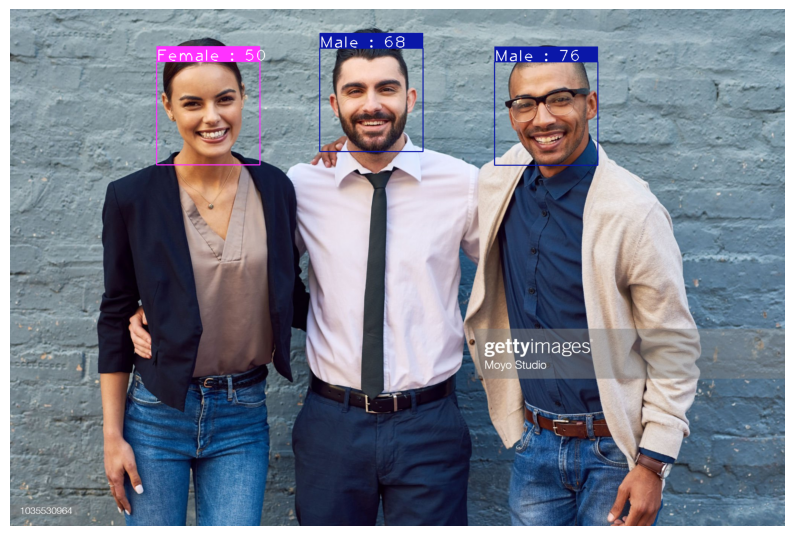

In [3]:
img_bgr = pipeline('./data/test_images/getty_test.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## Real Time Gender Recognition
- Given a path to a video, will predict on the video.

In [7]:
real_time('./data/test_images/video.mp4')

- Given no argument, will predict on video captured from camera.

In [2]:
real_time()

: 

In [1]:
import requests
r = requests.get('https://mobirise.com/extensions/financem4/paymentservices.html')

In [7]:
import bs4
soup = bs4.BeautifulSoup(r.text)
soup.contents

['html',
 '\n',
 <html>
 <head>
 <!-- Site made with Mobirise Website Builder v4.11.4, https://mobirise.com -->
 <meta charset="utf-8"/>
 <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
 <meta content="Mobirise v4.11.4, mobirise.com" name="generator"/>
 <meta content="width=device-width, initial-scale=1, minimum-scale=1" name="viewport"/>
 <link href="assets/images/logo2.png" rel="shortcut icon" type="image/x-icon"/>
 <meta content="New FinanceM4 HTML Template - Download Now!" name="description"/>
 <title>FinanceM4 Payment Services Demo</title>
 <link href="assets/web/assets/mobirise-icons2/mobirise2.css" rel="stylesheet"/>
 <link href="assets/web/assets/mobirise-icons/mobirise-icons.css" rel="stylesheet"/>
 <link href="assets/tether/tether.min.css" rel="stylesheet"/>
 <link href="assets/bootstrap/css/bootstrap.min.css" rel="stylesheet"/>
 <link href="assets/bootstrap/css/bootstrap-grid.min.css" rel="stylesheet"/>
 <link href="assets/bootstrap/css/bootstrap-reboot.min.css" rel="

In [ ]:
<!-- {% extends 'base.html' %}

{% block bodyblock %}

<div class="container">
    <br><br>
    <h3 class="fs-1">Facial Analysis Application</h3> <br>


    <div class="shadow-none p-3 mb-5 bg-light rounded">


        <p class="fs-5">
            There are 3 ways to explore the model: 
        </p>
        <br>
    
        <a class="btn btn-outline-primary btn-lg" href="/app/image/">By Image</a> <br> <br>
        <a class="btn btn-outline-primary btn-lg" href="/app/camera/">By Camera</a> <br> <br>
        <a class="btn btn-outline-primary btn-lg" href="/app/video">By Video</a>

    </div>

</div>

{% endblock %} -->